## Nonlinear pulse propagation

From Marc's paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib import cm

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

In [2]:
#Change size of plots
plt.rcParams['figure.figsize'] = [14, 5]

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [3]:
from scipy.constants import pi, c
c = c*1e-12; #mm/fs, [Freq]=PHz

## Single Pass

In [4]:
def single_pass(a,b,Da,Db,kappa,L,h,plot=False):
    zi = 0
    
    Da_h = Da**(h/2)
    Db_h = Db**(h/2)
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
        
    while zi<L:
        #Linear half step (front)
        A = np.fft.fft(a)
        A = A*Da_h
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db_h
        b = np.fft.ifft(B)
        
        #Nonlinear step
        #Runge-Kutta for a
        k1 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a)))
        k2 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k1/2)))
        k3 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k2/2)))
        k4 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k3)))
        a = a + (1/6)*(k1+2*k2+2*k3+k4)

        #Integral for b
#         b = b - 0.5*h*kappa*a*a
        b = b - h*np.fft.ifft(kappa*np.fft.fft(a*a))
        
        #Runge-Kutta for a
        k1 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a)))
        k2 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k1/2)))
        k3 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k2/2)))
        k4 = h/2*np.fft.ifft(kappa*np.fft.fft(b*np.conj(a+k3)))
        a = a + (1/6)*(k1+2*k2+2*k3+k4)
        
        #Linear half step (back)
        A = np.fft.fft(a)
        A = A*Da_h
        a = np.fft.ifft(A)
        B = np.fft.fft(b)
        B = B*Db_h
        b = np.fft.ifft(B)
        
        #Next z
        zi = zi+h

        if plot==True and zi%2<0.1:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            fig.canvas.draw()
            time.sleep(0.001)

    return a,b

## OPO

In [23]:
def opo(b_input, N, L, h, Da, Db, fb, kappa, plot=False):
    '''
    Inputs:
    b: pump pulse
    N: number of rountrips
    L: length of the crystal
    h: spatial step on the crystal
    Da: Dispersion operator of crystal at signal
    Db: Dispersion operator of crystal at pump
    fb: Feedback operator
    kappa: nonlinear coupling
    plot: if True it will try to plot the output of each roundtrip
    
    Outputs:
    a: signal pulse after N roundtrips
    b: pump pulse after last roundtrip
    '''
    
    #Initialize signal as random
    NFFT = b.size
    noise = np.random.normal(0,1e-10,NFFT)
    a = noise
    
    if plot==True:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.ion()
        fig.canvas.draw()
    
    evol = np.zeros([N, NFFT])
    for kn in range(N):
        a,b_output = single_pass(a,b_input,Da,Db,kappa,L,h)
            
        #Apply feedback
#         a = a*window
        A = np.fft.fft(a)
        A = A*fb
        a = np.fft.ifft(A)
        
        evol[kn,:]=(np.abs(a)/np.abs(np.max(a)))**2; #Round-trip evolution
        
        if kn%50==0 and kn!=0:
            print('Completed roundtrip ' + str(kn))
        
        if plot==True and kn%2==0:
            ax.clear()
            ax.plot(t, abs(a), t, abs(b));
            ax.axes.set_ylim(0,2000)
            ax.text(40,1400,'N=' + str(kn))
            ax.text(40,1200,'Pa=' + str(round(Pa*1e-8,3)))
            fig.canvas.draw()
            time.sleep(0.001)
            
    print('Completed roundtrip ' + str(kn+1)) 
    return a, b_output, evol

## Time and Frequency domain windows

In [6]:
#Simulation window setup
NFFT = 2**9 #Fourier size

Tmax = 1000 #(fs) window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =', ts, 'fs')
# window = np.hamming(N)

#Frequency domain
Omega = 2*pi*np.fft.fftfreq(t.size, ts) #Angular frequencies
print('Freq max =', np.amax(Omega)*1e3/(2*pi), 'THz')
print('Freq resolution =', Omega[1]*1e3/(2*pi), 'THz')

Sampling Rate = 3.9138943248532314 fs
Freq max = 127.25097656249991 THz
Freq resolution = 0.49902343749999967 THz


## Input parameters

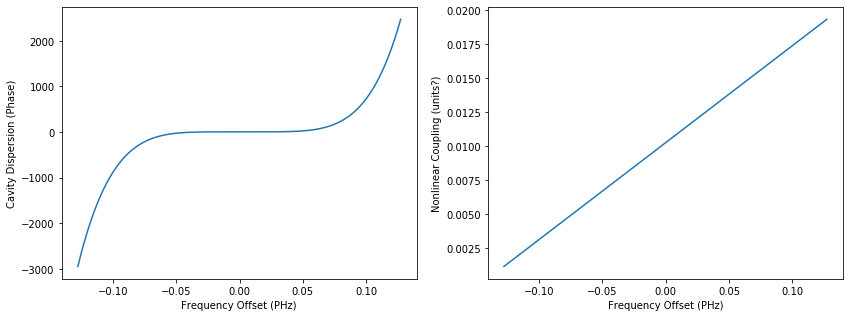

In [14]:
#Input parameters

#OPO parameters
wla = 2.090e-3 #signal wavelength (mm)
wlb = wla/2 #pump wavelength (mm)
wa = 2*pi*c/wla#
Co_loss = 1-0.65  #Output coupler loss
dT = 4 #Detuning in fs
l = c*dT/wlb #Detuning parameter l
pump_pwr = 0.5 #Average pump power (W)
Tp = 70 #Input pulse width (fs)
Ws = 14e-3 #Beam waist of signal (mm)

#Cavity dispersion parameters
phi2 = 25
phi3 = 76
phi4 = -13020
phi5 = 983328

#Crystal parameters
L = 1 #mm
alpha_a = 0.00691 #loss for signal in crystal (1/mm)
alpha_b = 0.00691 #loss for pump in crystal (1/mm)
u = 112.778 #Group velocity mismatch (fs/mm)
b2a = -53.64 #second order GVD signal (fs^2/mm)
b3a = 756.14 #third order GVD signal (fs^3/mm)
b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
b2b = 240.92 #second order GVD pump (fs^2/mm)
b3b = 211.285 #second order GVD pump (fs^3/mm)
b4b = -18.3758 #second order GVD pump (fs^4/mm)
deff = 2/pi*16e-9 #effective nonlinear coefficient (mm/V)
na = 2.2333# refractive index at signal
nb = 2.1935# refractive index at pump

kappa = np.sqrt(2*377)*deff*(Omega+wa)/(Ws*na*c*np.sqrt(pi*nb)) #Nonlinear coupling
# kappa = np.clip(kappa, a_min=0, a_max=None)

#Linear operators
# Da = np.exp(-alpha_a/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6 + 1j*b4a*Omega**4/24)
# Db = np.exp(-alpha_b/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6 + 1j*b4b*Omega**4/24)
Da = np.exp(-alpha_a/2 + 1j*b2a*Omega**2/2 + 1j*b3a*Omega**3/6 + 1j*b4a*Omega**4/24)
Db = np.exp(-alpha_b/2 + 1j*u*Omega + 1j*b2b*Omega**2/2 + 1j*b3b*Omega**3/6 + 1j*b4b*Omega**4/24)

#Feedback loop
deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 + (phi4/24)*Omega**4 + (phi5/120)*Omega**5
phi = pi*l + l*(wla*1e-3)/(2*c)*Omega + deltaphi
fb = np.sqrt(Co_loss)*np.exp(-1j*phi)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(np.fft.fftshift(Omega)/(2*pi), np.fft.fftshift(phi));
ax2.plot(np.fft.fftshift(Omega)/(2*pi), np.fft.fftshift(kappa));
ax1.set_xlabel('Frequency Offset (PHz)');
ax2.set_xlabel('Frequency Offset (PHz)');
ax1.set_ylabel('Cavity Dispersion (Phase)');
ax2.set_ylabel('Nonlinear Coupling (units?)');

## Pump pulse shape

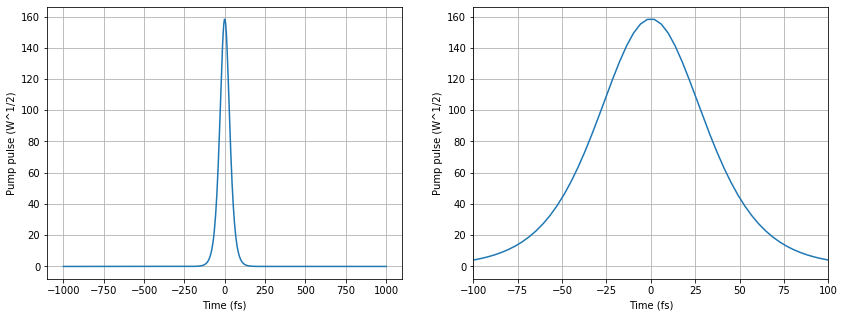

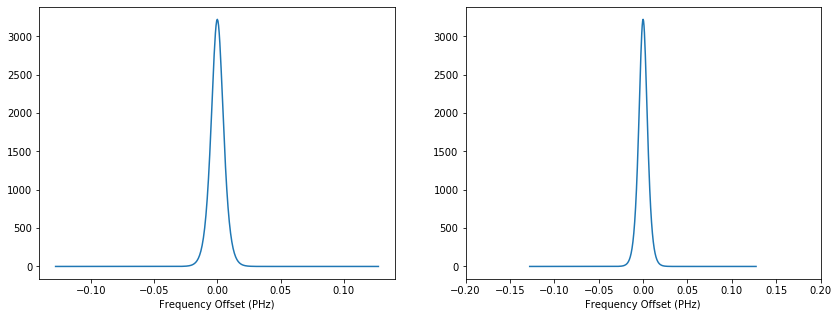

In [8]:
# t0 = -Tp
t0 = 0
tau = Tp/1.76
b = np.sqrt(0.88*4e6/Tp*pump_pwr)/np.cosh((t-t0)/tau)**2
B = np.fft.fft(b,NFFT)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,b)
ax1.grid()
ax2.plot(t,b)
ax2.grid()
ax2.set_xlim(-100,100)
ax1.set_xlabel('Time (fs)');
ax2.set_xlabel('Time (fs)');
ax1.set_ylabel('Pump pulse (W^1/2)');
ax2.set_ylabel('Pump pulse (W^1/2)');

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(np.fft.fftshift(Omega)/(2*pi),np.fft.fftshift(np.abs(B)))
ax2 = fig.add_subplot(122)
ax2.plot(np.fft.fftshift(Omega)/(2*pi),np.fft.fftshift(np.abs(B)))
ax2.set_xlim(-0.2,0.2)
ax1.set_xlabel('Frequency Offset (PHz)');
ax2.set_xlabel('Frequency Offset (PHz)');

## Single Pass Test

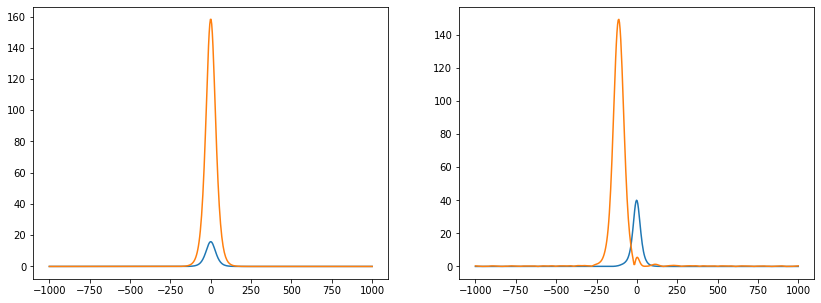

In [15]:
h = L/50 #Distance step Size

a = b/10

a_out, b_out = single_pass(a,b,Da,Db,kappa,L,h)
# a_out, b_out = single_pass(a,b,Da,Db,0.01,L,h)

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(t,abs(a),t,abs(b));
ax1 = fig.add_subplot(122)
ax1.plot(t,abs(a_out),t,abs(b_out));

## OPO Test

In [24]:
a_out, b_out, evol = opo(b, 600, L, h, Da, Db, fb, kappa, plot=False)

Completed roundtrip 50
Completed roundtrip 100
Completed roundtrip 150
Completed roundtrip 200
Completed roundtrip 250
Completed roundtrip 300
Completed roundtrip 350
Completed roundtrip 400
Completed roundtrip 450
Completed roundtrip 500
Completed roundtrip 550
Completed roundtrip 600


(-1, 1)

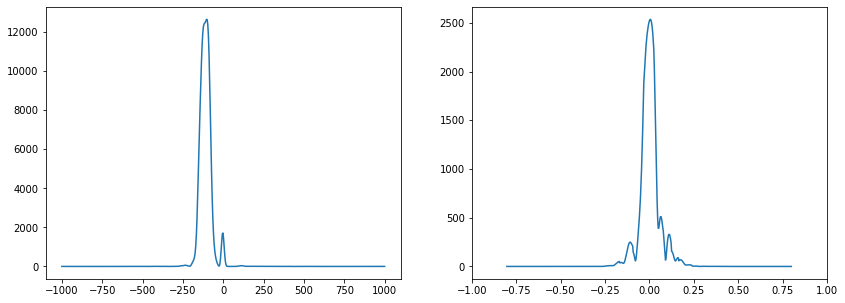

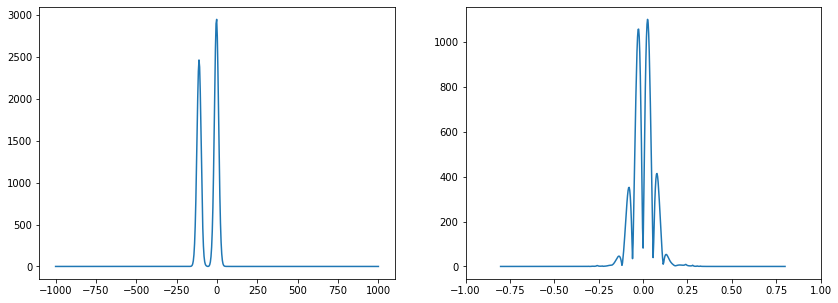

In [18]:
B = np.fft.fftshift(np.fft.fft(b_out))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,np.abs(b_out)**2)
ax2.plot(np.fft.fftshift(Omega), np.abs(B))
ax2.set_xlim(-1,1)

A = np.fft.fftshift(np.fft.fft(a_out))
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,np.abs(a_out)**2)
ax2.plot(np.fft.fftshift(Omega), np.abs(A))
ax2.set_xlim(-1,1)

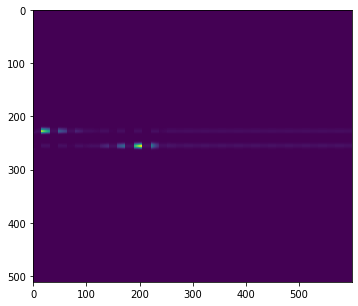

In [27]:
plt.imshow(np.transpose(evol))

## Sweep Detuning

In [12]:
# #Sweep detuning
# # phi0 = np.arange(-0.3,0.3,0.05)
# # l = np.arange(-0.1,0.1,0.01)
# l = np.arange(-1.5,1.5,0.02)

# a_sweep = np.zeros((l.size,N), dtype=complex)

# # # 
# for k in range(l.size):
#     a_sweep[k,:], Pa = opo(l=l[k], p=2, G0=1/0.35, h=0.5, plot=False)
    
#     pc = str(((k+1)/l.size)*100) + '% complete'
#     print('l = ' + str(round(l[k],5)) + ' done; ' + pc)
    

In [13]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fig.canvas.draw()
# ax.clear()

# Spectrum = np.zeros(a_sweep.shape)

# for k in range(l.size):
#     A = np.fft.fft(a_sweep[k,:])
#     Spectrum[k,:] = np.abs(A)**2
# #     Spectrum[k,:] = 20*np.log10(np.abs(A))

# Amax = np.amax(Spectrum)
# Spectrum_dB = 10*np.log10(Spectrum/Amax)
# # ax.imshow(np.fft.fftshift(Spectrum_dB), extent=(-0.4,0.4,-0.4,0.4));
# ax.imshow(np.fft.fftshift(Spectrum_dB));